In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import copy
import time
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import copy
import time
import torch
import syft as sy
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn import metrics
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import seaborn as sns

In [2]:
class Arguments():
    def __init__(self):
        self.images = 60000
        self.clients = 3
        self.rounds = 10
        self.epochs = 3
        self.local_batches = 128
        self.lr = 0.01
        self.C = 0.9
        self.drop_rate = 0.1
        self.torch_seed = 0
        self.log_interval = 100
        self.iid = 'iid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = False

args = Arguments()

use_cuda = args.use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
hook = sy.TorchHook(torch)#Create virtual machine
clients = []#[{'hook': <VirtualWorker id:client1 #objects:0>},{'hook': <VirtualWorker id:client2 #objects:0>},............]
for i in range(args.clients):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})

In [4]:
class ZdyDataset():  # Build our own class and inherit all features and functions from the dataset
    def __init__(self,mode):
        self.Data, self.Labels,self.total_len = self.load_csv()
        print("total_len",self.total_len )
        if mode == 'train':  # 60%
            self.data = self.Data[:int(0.7 * self.total_len)]
            self.labels = self.Labels[:int(0.7*self.total_len)]
        elif mode == 'test':  # 20%
            # Use the remaining 30% of the data set as the verification set
            self.data = self.Data[int(0.7*self.total_len):]
            self.labels = self.Labels[int(0.7*self.total_len):]

    def load_csv(self):
        Data, Labels = [], []
        root ='C:/Users/lenovo/ADAC.csv'
        data= pd.read_csv(root) 
        data=data.iloc[:10000,:]
        total_len = data.shape[0]
        f=data.replace(np.NaN,0)
        #f= data.iloc[:182771]
        
        close_max,close_min=f['price'].max(),f['price'].min()
        print("highest=", close_max)
        print("lowest=", close_min)
        df = f
        print(df.shape[0])
        #df = f.apply(lambda x:(x-min(x))/(max(x)-min(x)))
        #Check the normalized data range: between [0,1]
        close_max_n = df["price"].max()
        close_min_n = df['price'].min()
        d = f.apply(lambda x:(x-min(x))/(max(x)-min(x)))
        d = f
        total_len = df.shape[0]
        for i in range(df.shape[0]):
            data =d.iloc[i:(i+1),6:] # i:(i+sequence),:-2
            label=f.iloc[i][5]
           
            Data.append(data)
            Labels.append(label)
        assert len(Data) == len(Labels)
        print("train data  of item  0: \n", Data[0])
        print("train label of item  0: \n", Labels[0])
        return Data, Labels,total_len

    
    def __len__(self):  # Returns the size of the actual dataset
        return len(self.data)

    def __getitem__(self, idx):  # Returning it will accept self and item and return labels, each of which is equal
        data, label = self.data[idx], self.labels[idx]
       
     
        data = torch.tensor(data.values, dtype=torch.float)

        label = np.array(label)
        label = torch.tensor(label, dtype=torch.long)
#         print(data, label)
        return data, label

train_dataset =ZdyDataset('train')
test_dataset = ZdyDataset('test')

In [5]:
class ZdyDataset():  # Build our own class and inherit all features and functions from the dataset
    def __init__(self,mode):
        self.Data, self.Labels,self.total_len = self.load_csv()
        print("total_len",self.total_len )
        if mode == 'train':  # 60%
            self.data = self.Data[:int(0.7 * self.total_len)]
            self.labels = self.Labels[:int(0.7*self.total_len)]
        elif mode == 'test':  # 20%
            # Use the remaining 30% of the data set as the verification set
            self.data = self.Data[int(0.7*self.total_len):]
            self.labels = self.Labels[int(0.7*self.total_len):]

    def load_csv(self):
        Data, Labels = [], []
        root ='C:/Users/lenovo/CTRD.csv'
        data= pd.read_csv(root) 
        data=data.iloc[:10000,:]
        total_len = data.shape[0]
        f=data.replace(np.NaN,0)
        #f= data.iloc[:182771]
        
        close_max,close_min=f['price'].max(),f['price'].min()
        print("highest=", close_max)
        print("lowest=", close_min)
        df = f
        print(df.shape[0])
        #df = f.apply(lambda x:(x-min(x))/(max(x)-min(x)))
        #Check the normalized data range: between [0,1]
        close_max_n = df["price"].max()
        close_min_n = df['price'].min()
        d = f.apply(lambda x:(x-min(x))/(max(x)-min(x)))
        d = f
        total_len = df.shape[0]
        for i in range(df.shape[0]):
            data =d.iloc[i:(i+1),6:] # i:(i+sequence),:-2
            label=f.iloc[i][5]
           
            Data.append(data)
            Labels.append(label)
        assert len(Data) == len(Labels)
        print("train data  of item  0: \n", Data[0])
        print("train label of item  0: \n", Labels[0])
        return Data, Labels,total_len

    
    def __len__(self):  # Returns the size of the actual dataset
        return len(self.data)

    def __getitem__(self, idx):  # Returning it will accept self and item and return labels, each of which is equal
        data, label = self.data[idx], self.labels[idx]
       
     
        data = torch.tensor(data.values, dtype=torch.float)

        label = np.array(label)
        label = torch.tensor(label, dtype=torch.long)
#         print(data, label)
        return data, label

train_dataset1 =ZdyDataset1('train')
test_dataset1 = ZdyDataset1('test')

In [6]:
for inx, client in enumerate(clients):
    #trainset_ind_list = list(train_group[inx])
    #client['trainset'] = getActualImgs(global_train, trainset_ind_list, args.local_batches)
    #client['testset'] = getActualImgs(global_test, list(test_group[inx]), args.local_batches)
    client['train_loader'] = DataLoader(train_dataset, batch_size=batch_size)
    #client['test_loader'] = DataLoader(test_dataset, batch_size=batch_size)
    client['samples'] = (len(train_dataset)/len(clients)) / args.images

In [7]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
class Rnn(nn.Module):#Rnn(28, 10, 3, 10)
    def __init__(self):
        super(Rnn, self).__init__()

        # Put the batch_ Size in the first dimension
        # Use two-way loop LSTM
        self.lstm = nn.LSTM(17, 128, 3, batch_first=True, bidirectional=True)

        # The last linear layer of the network
        #self.classifier1 = nn.Linear(128, 20)
        self.classifier = nn.Sequential( nn.Dropout(0.2),
                                        nn.Linear(128, 64),
                                        nn.Sigmoid(),
                                        nn.Linear(64, 32),
                                        nn.Sigmoid(),
                                        nn.Linear(32, 14),
                                        nn.Sigmoid() )



    def forward(self, input): # input [128, 28, 28]
        
        out, (h_n, c_n) = self.lstm(input)

        # x = out[:, -1, :] # Get the final output status h from out
        x = h_n[-1, :, :]
        #x = F.relu(self.classifier(x))
        x = self.classifier(x)

#         x = F.relu(self.classifier2(x))
#         x = self.classifier3(x)
        return x

In [10]:
def train(args, device, client):#train(epoch)
    
    
    #def train(args, model, device, train_loader, optimizer, epoch):#train(epoch)
    
    client['model'].train()
    train_loss = 0
    correct = 0
    total = 0
    for epoch in range(1, args.epochs + 1):
        for batch_idx, (inputs, targets) in enumerate(client['train_loader']):

            inputs, targets = inputs.to(device), targets.to(device)

            client['optim'].zero_grad()
            outputs = client['model'](torch.squeeze(inputs, 1))
            loss = criterion(outputs, targets)
            loss.backward()
            client['optim'].step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
#             if batch_idx % 100 == 0:
#                 print(batch_idx, 'Loss: %.3f | Acc: %.3f%% (%d/%d)'% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
#                 print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} | Acc: {}/{} ({:.5f}%)\n '.format(
#                     client['hook'].id,epoch,batch_idx * args.local_batches,len(client['train_loader']) * args.local_batches, 
#                     100. * batch_idx / len(client['train_loader']), loss, correct, total,100.*correct/total))                
            

                
                
def test(args, model, device):

    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():

    # inputs = [128, 1, 28, 28], targets = [128]
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            outputs = model(torch.squeeze(inputs, 1))
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        
    return test_loss, correct, correct, total,batch_idx

In [11]:
def averageModels(global_model, clients):#Average model
    client_models = [clients[i]['model'] for i in range(len(clients))]
    samples = [clients[i]['samples'] for i in range(len(clients))]
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() * samples[i] for i in range(len(client_models))], 0).sum(0) 
    global_model.load_state_dict(global_dict)
    return global_model

In [18]:
torch.manual_seed(args.torch_seed)#Send to device
global_model= Rnn(28, 10, 3, 10)
# define the optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(client['model'].parameters(), lr=0.1)


for client in clients:#Traverse all client lists
    #The model created with net is sent to the device, and the optimizer created with optimdot calls the desired class as SGD. The optimizer accepts parameters
    torch.manual_seed(args.torch_seed)#Set Seed
    client['model'] = Rnn(28, 10, 3, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    client['optim'] = optim.SGD(client['model'].parameters(), lr=0.1)
    
for fed_round in range(args.rounds):
    m = int(max(args.C * args.clients, 1))
   
    # Selected devices
    np.random.seed(fed_round)
    #From the range (len (clients)), randomly select the data with the size of m, and replace indicates whether to reuse the element
    #That is, whether the extracted data is put back into the original array. The default is true (the extracted data has duplicates)
    selected_clients_inds = np.random.choice(range(len(clients)), m, replace=False)

    selected_clients = [clients[i] for i in selected_clients_inds]
  
    # Active devices
    np.random.seed(fed_round)
    active_clients_inds = np.random.choice(selected_clients_inds, int((1-args.drop_rate) * m), replace=False)
    active_clients = [clients[i] for i in active_clients_inds]
    
    
    # train the clients
    for client in active_clients:
        #train(epoch)
        train(args, device, client)
        
    # Averaging 
    global_model = averageModels(global_model, active_clients)
    
    # Testing the average model
        
    for client in active_clients:
        test_loss, correct, correct, total,batch_idx=test(args, client['model'], device)
    print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

        
    for client in clients:
        client['model'].load_state_dict(global_model.state_dict())
        
        
# save the global model
if args.save_model:
    torch.save(global_model.state_dict(), "federated_mnist.pt")

Loss: 0.319 | Acc: 91.440% (9144/10000)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loss: 0.152 | Acc: 96.070% (9607/10000)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loss: 0.134 | Acc: 96.680% (9668/10000)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loss: 0.130 | Acc: 96.590% (9659/10000)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loss: 0.144 | Acc: 96.220% (9622/10000)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loss: 0.115 | Acc: 96.970% (9697/10000)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loss: 0.11

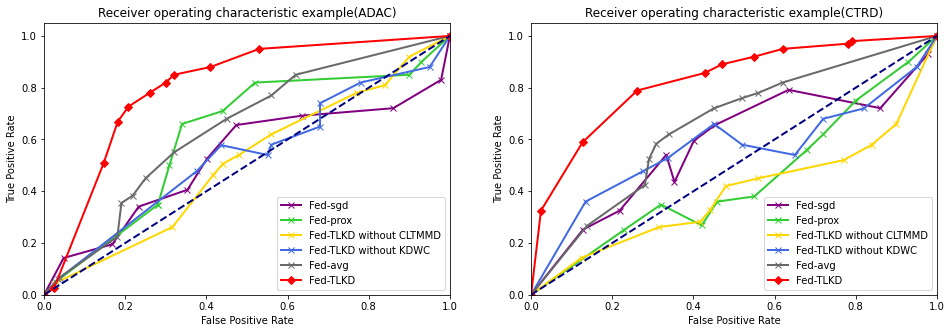

In [16]:
plt.figure(figsize=(16, 5))
lw = 2

plt.subplot(1,2,1)
plt.plot(a2, a1, color='purple',marker='x',lw=lw, label='Fed-sgd' % auc1)
plt.plot(d2, d1, color='limegreen',marker='x',lw=lw, label='Fed-prox' % auc4)
plt.plot(e2, e1, color='gold',marker='x',lw=lw, label='Fed-TLKD without CLTMMD' % auc5)
plt.plot(f2, f1, color='royalblue',marker='x',lw=lw, label='Fed-TLKD without KDWC' % auc6)
plt.plot(b2, b1, color='dimgrey',marker='x',lw=lw, label='Fed-avg' % auc2)
plt.plot(c2, c1, color='red',marker='D',lw=lw, label='Fed-TLKD' % auc3)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example(ADAC)')
plt.legend(loc='lower right',ncol=1)

plt.subplot(1,2,2)
plt.plot(a22, a11, color='purple',marker='x',lw=lw, label='Fed-sgd' % auc11)
plt.plot(d22, d11, color='limegreen',marker='x',lw=lw, label='Fed-prox' % auc44)
plt.plot(e22, e11, color='gold',marker='x',lw=lw, label='Fed-TLKD without CLTMMD' % auc55)
plt.plot(f22, f11, color='royalblue',marker='x',lw=lw, label='Fed-TLKD without KDWC' % auc66)
plt.plot(b22, b11, color='dimgrey',marker='x',lw=lw, label='Fed-avg' % auc22)
plt.plot(c22, c11, color='red',marker='D',lw=lw, label='Fed-TLKD' % auc33)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example(CTRD)')
plt.legend(loc='lower right',ncol=1)

plt.savefig("auc.pdf")
plt.show()

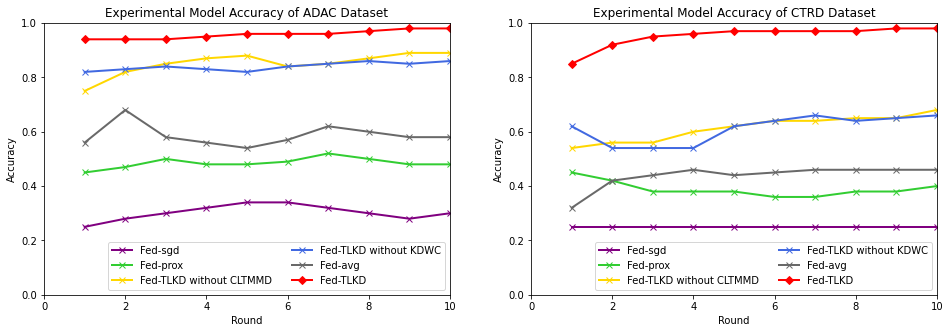

In [17]:
plt.figure(figsize=(16, 5))
lw = 2

plt.subplot(1,2,1)
plt.plot(ac, ac4, color='purple',marker='x',lw=lw, label='Fed-sgd')
plt.plot(ac, ac3, color='limegreen',marker='x',lw=lw, label='Fed-prox')
plt.plot(ac, ac2, color='gold',marker='x',lw=lw, label='Fed-TLKD without CLTMMD')
plt.plot(ac, ac1, color='royalblue',marker='x',lw=lw, label='Fed-TLKD without KDWC')
plt.plot(ac, ac5, color='dimgrey',marker='x',lw=lw, label='Fed-avg')
plt.plot(ac, ac6, color='red',marker='D',lw=lw, label='Fed-TLKD')
plt.xlim([0.0, 10.0])
plt.ylim([0.0, 1])
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Experimental Model Accuracy of ADAC Dataset')
plt.legend(loc='lower right',ncol=2)

plt.subplot(1,2,2)
plt.plot(ac, ac44, color='purple',marker='x',lw=lw, label='Fed-sgd')
plt.plot(ac, ac33, color='limegreen',marker='x',lw=lw, label='Fed-prox')
plt.plot(ac, ac22, color='gold',marker='x',lw=lw, label='Fed-TLKD without CLTMMD')
plt.plot(ac, ac11, color='royalblue',marker='x',lw=lw, label='Fed-TLKD without KDWC')
plt.plot(ac, ac55, color='dimgrey',marker='x',lw=lw, label='Fed-avg')
plt.plot(ac, ac66, color='red',marker='D',lw=lw, label='Fed-TLKD')
plt.xlim([0.0, 10.0])
plt.ylim([0.0, 1])
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Experimental Model Accuracy of CTRD Dataset')
plt.legend(loc='lower right',ncol=2)

plt.savefig("acc.pdf")
plt.show()

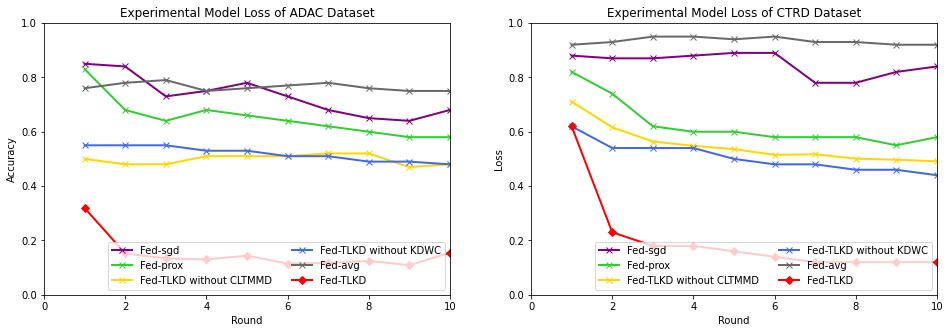

In [18]:
plt.figure(figsize=(16, 5))
lw = 2

plt.subplot(1,2,1)
plt.plot(ac, lo4, color='purple',marker='x',lw=lw, label='Fed-sgd')
plt.plot(ac, lo3, color='limegreen',marker='x',lw=lw, label='Fed-prox')
plt.plot(ac, lo2, color='gold',marker='x',lw=lw, label='Fed-TLKD without CLTMMD')
plt.plot(ac, lo1, color='royalblue',marker='x',lw=lw, label='Fed-TLKD without KDWC')
plt.plot(ac, lo5, color='dimgrey',marker='x',lw=lw, label='Fed-avg')
plt.plot(ac, lo6, color='red',marker='D',lw=lw, label='Fed-TLKD')
plt.xlim([0.0, 10.0])
plt.ylim([0.0, 1])
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Experimental Model Loss of ADAC Dataset')
plt.legend(loc='lower right',ncol=2)

plt.subplot(1,2,2)
plt.plot(ac, lo44, color='purple',marker='x',lw=lw, label='Fed-sgd')
plt.plot(ac, lo33, color='limegreen',marker='x',lw=lw, label='Fed-prox')
plt.plot(ac, lo22, color='gold',marker='x',lw=lw, label='Fed-TLKD without CLTMMD')
plt.plot(ac, lo11, color='royalblue',marker='x',lw=lw, label='Fed-TLKD without KDWC')
plt.plot(ac, lo55, color='dimgrey',marker='x',lw=lw, label='Fed-avg')
plt.plot(ac, lo66, color='red',marker='D',lw=lw, label='Fed-TLKD')
plt.xlim([0.0, 10.0])
plt.ylim([0.0, 1])
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Experimental Model Loss of CTRD Dataset')
plt.legend(loc='lower right',ncol=2)

plt.savefig("loss.pdf")
plt.show()